# Introduction

Hey, we're going to run some data analysis on the data from the `GNOME Open Desktop Ratings` projects. You can find it here: https://odrs.gnome.org/
It's the backend, that enables Gnome Software to show you user ratings for apps or let you write some.
It's used by distros such as Ubuntu, Fedora, Zorin etc. we will dig into this later.

We actually grabbed the data we want with the deno script, that you can find in the `export` folder.

Now let's prepare the data about app ratings:

In [2]:
import pandas as pd
import math
import scipy.stats as st
import matplotlib.pyplot as plt

def bayesian_rating_confidence(n, confidence=0.95):
    """
    Function to calculate wilson score for N star rating system. 
    :param n: Array having count of star ratings where ith index represent the votes for that category i.e. [3, 5, 6, 7, 10]
    here, there are 3 votes for 1-star rating, similarly 5 votes for 2-star rating. 
    :param confidence: Confidence interval
    :return: Score
    """
    if sum(n)==0:
        return 0
    K = len(n)
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    N = sum(n)
    first_part = 0.0
    second_part = 0.0
    for k, n_k in enumerate(n):
        first_part += (k+1)*(n[k]+1)/(N+K)
        second_part += (k+1)*(k+1)*(n[k]+1)/(N+K)
    score = first_part - z * math.sqrt((second_part - first_part*first_part)/(N+K+1))
    return score

df = pd.read_json("export/data/apps.json").T

df["star_average"] = sum([i*df ["star%d" % i] for i in range(1, 6)]) / sum(([df ["star%d" % i] for i in range(1, 6)]))

df["confidence"] = df.apply(lambda row : bayesian_rating_confidence([row["star%d" % i] for i in range(1,6)]), axis=1)

And the data for all reviews ever done:

In [3]:
reviewsDf = pd.read_json("export/data/reviews.json")

reviewsDf = reviewsDf.drop_duplicates(subset=["review_id"])

reviewsDf["locale"] = reviewsDf["locale"].str.lower()
reviewsDf["locale"] = reviewsDf["locale"].replace(to_replace="(\.utf(-|_|\.)?8)?(@\w+)?$", value="" , regex=True)

reviewsDf["date_created"] = pd.to_datetime(reviewsDf["date_created"], unit="s")

reviewsDf["rating"] = reviewsDf["rating"].astype(int)/20

# How ratings are distributed

Let's look how apps are rated from one to five stars looking at all apps we have, every circle is the count ratings an app got for that star:

<AxesSubplot:title={'center':'Number of ratings per app'}, ylabel='Number of ratings'>

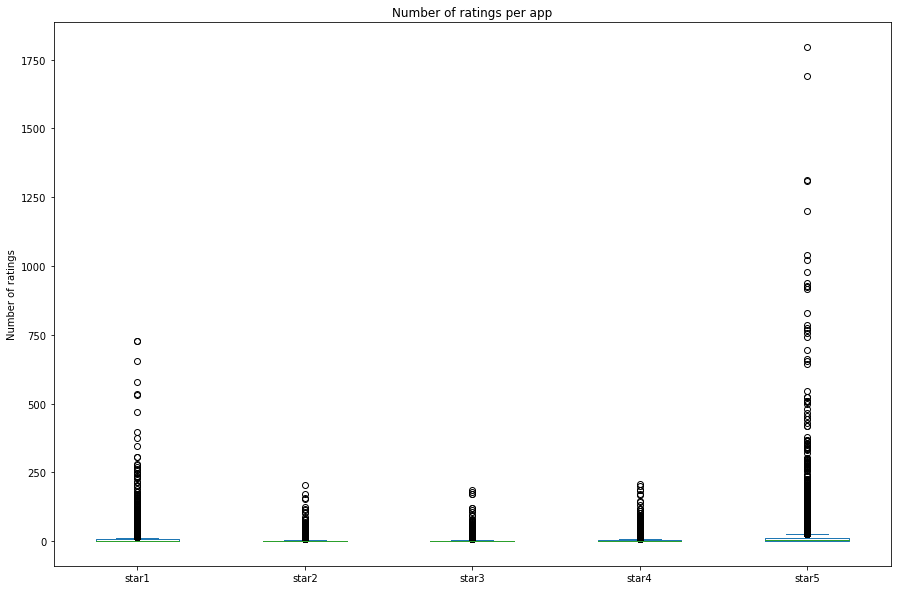

In [4]:
df[["star1", "star2", "star3", "star4", "star5"]].plot.box(title="Number of ratings per app", ylabel="Number of ratings", xlabel="Star rating", figsize=(15, 10))

So it seems like there are far more apps with one stars and five stars then everything else. Not very suprising so far.

So let's look at the raw data and figure out what the mean for each rating is. This should help application authors to see how their app performs relativly to the rest of the ecosystem.

<AxesSubplot:title={'center':'Distribution of ratings over all apps'}, xlabel='Star rating', ylabel='Number of ratings'>

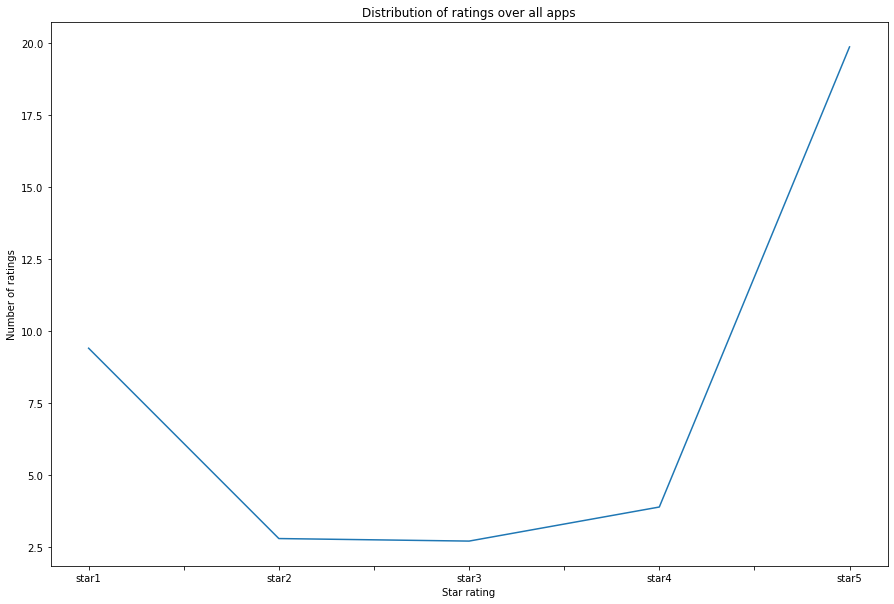

In [5]:
df[["star1", "star2", "star3", "star4", "star5"]].mean().plot(title="Distribution of ratings over all apps", ylabel="Number of ratings", xlabel="Star rating", figsize=(15, 10))

So if your apps ratings are anywhere near this line, your doing fine, at least relative to the ecosystem.

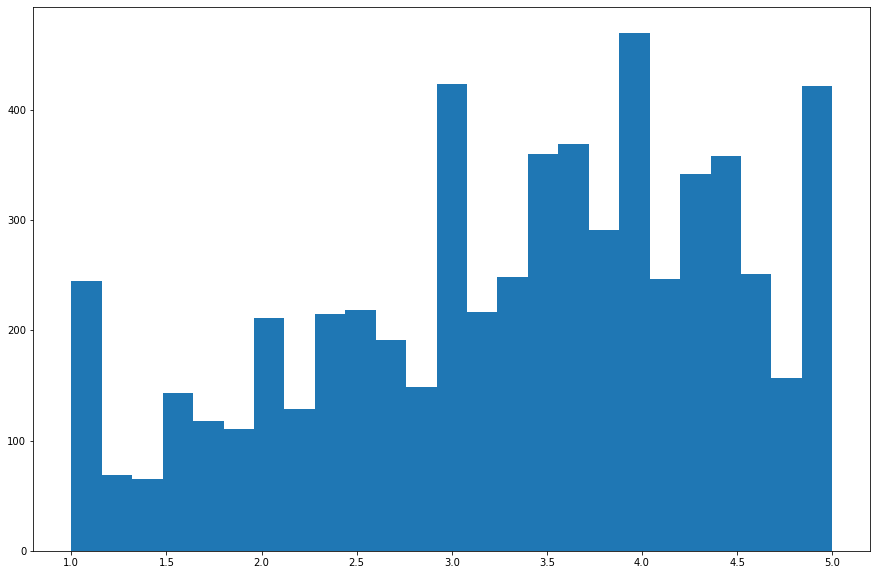

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))

n, bins, patches = ax.hist(x=df["star_average"], bins=25)

group = df.groupby(pd.cut(df.star_average, bins))

So the most ratings seem to be between 3.0 to 5.0, which is a healthy sign. But it could always be shifted more towards 5.

# Top apps

Have a look at the top rated apps, unfortunatly there are some duplicates here:

In [7]:
df.nlargest(20,"confidence")[["star_average", "confidence", "total"]]

,star_average,confidence,total
dash-to-panel_jderose9.github.com,4.850829,4.695125,181
code-url-handler.desktop,4.681667,4.621098,1200
org.speedcrunch.SpeedCrunch,4.962963,4.617511,54
speedcrunch.desktop,4.962963,4.617511,54
io.snapcraft.sublime-text-2kOIsSRmQ7zjpIxzZDpoXaZOVejqaGOT,4.698582,4.611051,564
cool-retro-term.desktop,4.743316,4.586160,187
io.snapcraft.cool-retro-term-6d6yw8CVhAYys3Z09b4sGSwzXSWR6btg,4.743316,4.586160,187
code.desktop,4.636835,4.581329,1542
io.snapcraft.code-Ht0aUHi7ofh9Fbwh6m7jUN2pAy6kzBiu,4.635891,4.580252,1538
com.bitwarden.desktop,4.729258,4.574745,229


I also tried to look at how many apps did not have any ratings, but these don't seem to show in the dataset.

# Locales

So which languages are these user reviews written in? (Or well what is the system language they're coming from at least)

<AxesSubplot:title={'center':'Distribution of reviews per locale'}>

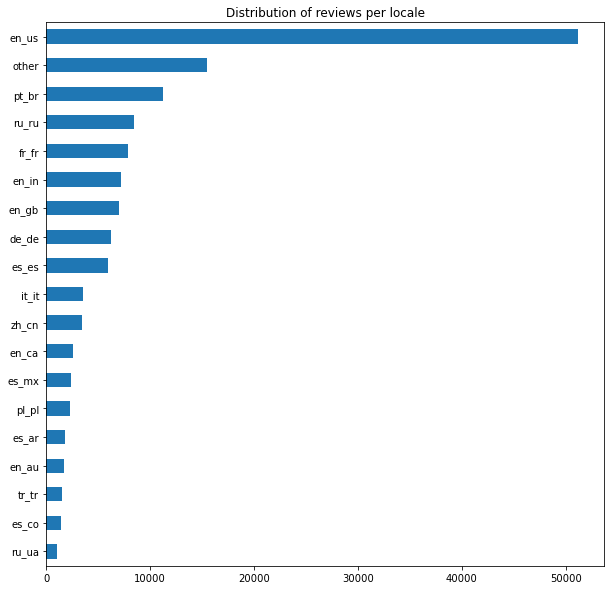

In [10]:
prob_locale = reviewsDf["locale"].value_counts()

mask = prob_locale > 1000
tail_prob_locale = prob_locale.loc[~mask].sum()
prob_locale = prob_locale.loc[mask]
prob_locale['other'] = tail_prob_locale
prob_locale.sort_values().plot(kind='barh', figsize=(10, 10), title="Distribution of reviews per locale")

American english being in the lead is hardly surprising. It get's a bit more interesting after that. `Other` still showing up so high, might be a good thing.

We seem to have reviews in about 200 locales (language_region):

In [11]:
reviewsDf["locale"].unique().size

198

# Distributions

So which distros are these reviews coming from?

<AxesSubplot:title={'center':'Distribution of reviews per distribution'}>

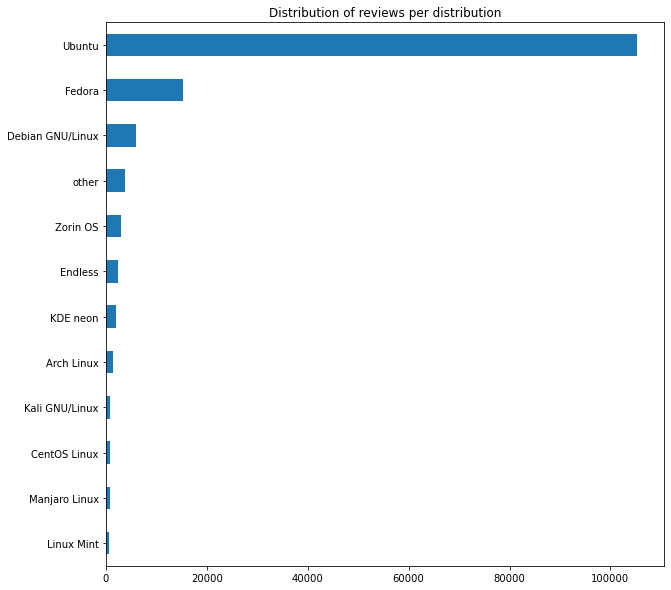

In [17]:
prob_distro = reviewsDf["distro"].value_counts()

mask = prob_distro > 500
tail_prob_distro = prob_distro.loc[~mask].sum()
prob_distro = prob_distro.loc[mask]
prob_distro['other'] = tail_prob_distro
prob_distro.sort_values().plot(kind='barh', figsize=(10, 10), title="Distribution of reviews per distribution")

Whew, Ubuntu seems to be far ahead. I'm not too sure if it's just, that Ubuntu is that much bigger, that they just package more applications or something else.

I'm not sure, why distros like Arch and Manjaro even show up here, as they usually use the their own package repos and the AUR.

So how many reviews does the system get per day, over the last years?

<AxesSubplot:title={'center':'Number of reviews per day'}, xlabel='date_created'>

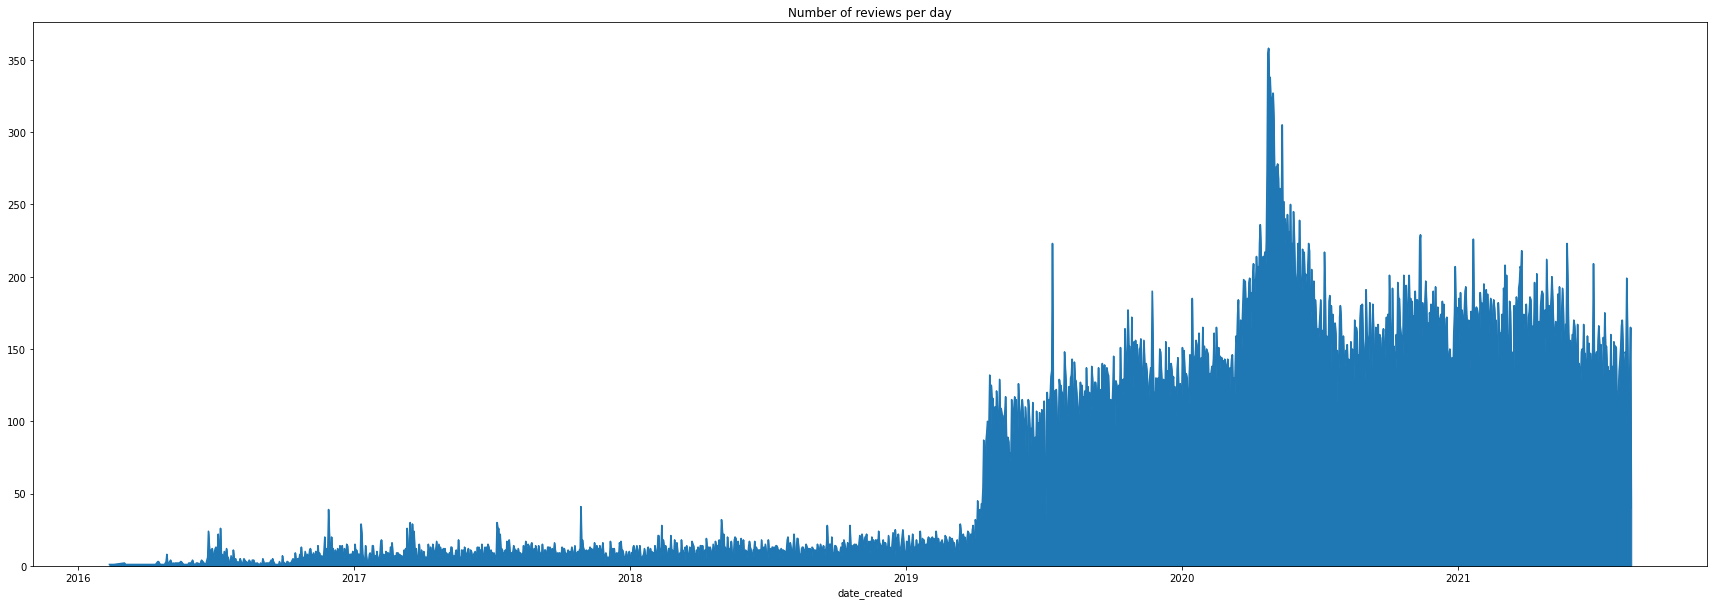

In [12]:
reviewsDf.groupby(reviewsDf['date_created'].dt.date)["date_created"].count().plot(kind='area', figsize=(30, 10), title="Number of reviews per day")

There are some sharp increases here, let's dig into them.

Let's see how these separate into the top 5 linux distributions by rating count:

<AxesSubplot:title={'center':'Number of reviews per day per distribution'}, xlabel='date_created'>

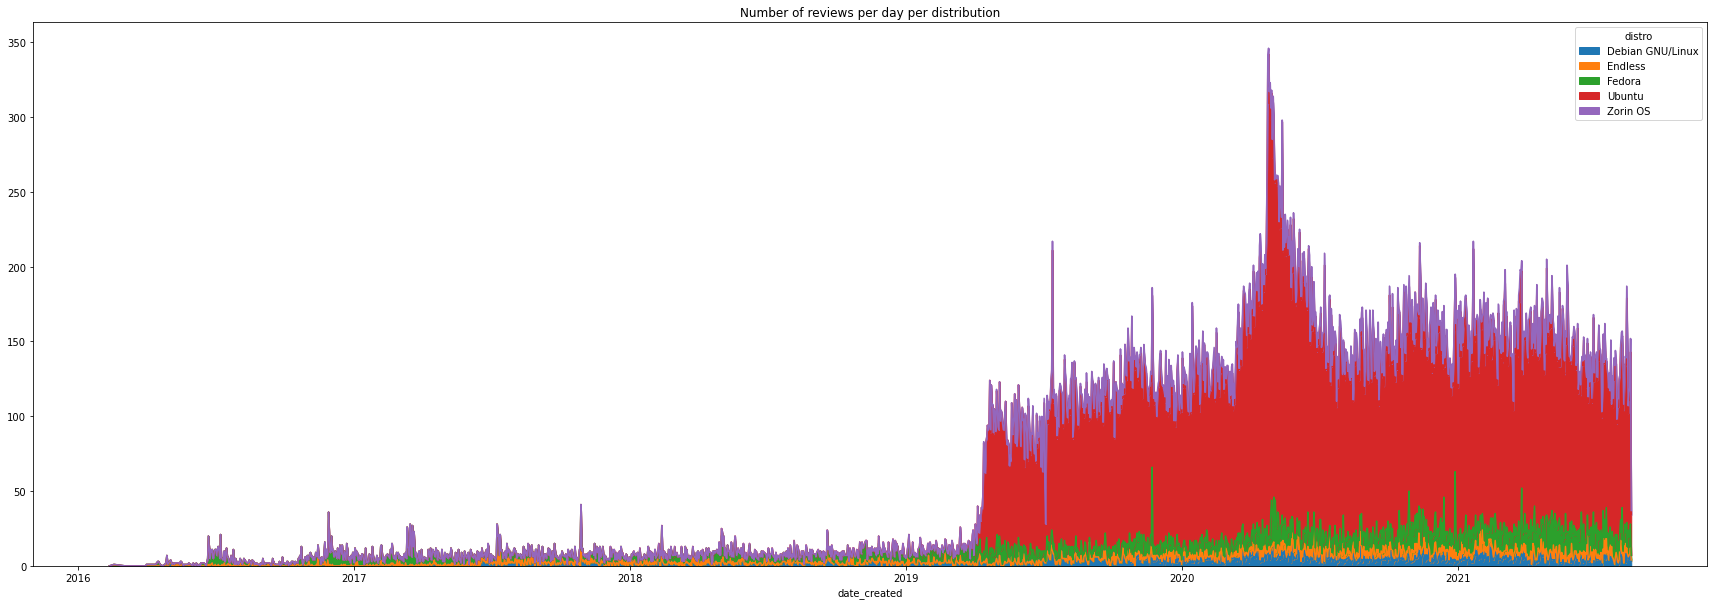

In [13]:
pivot_table = reviewsDf.groupby([reviewsDf["date_created"].dt.date,"distro"])["date_created"].count().unstack()
top5_distros = prob_distro.index.map(lambda x: x).tolist()[:5]
pivot_table.loc[:,pivot_table.columns.isin(top5_distros)].plot(kind='area', figsize=(30, 10), title="Number of reviews per day per distribution")

So in the middle of 2019 it seems like ubuntu people started to send in reviews and basically dwarf every other group. There's also a peak mid 2020, which might be covid related.

# Ratings over time

Let's see if there ever was a timeframe, where people started to rate differently.

<AxesSubplot:title={'center':'Average rating per day'}, xlabel='date_created'>

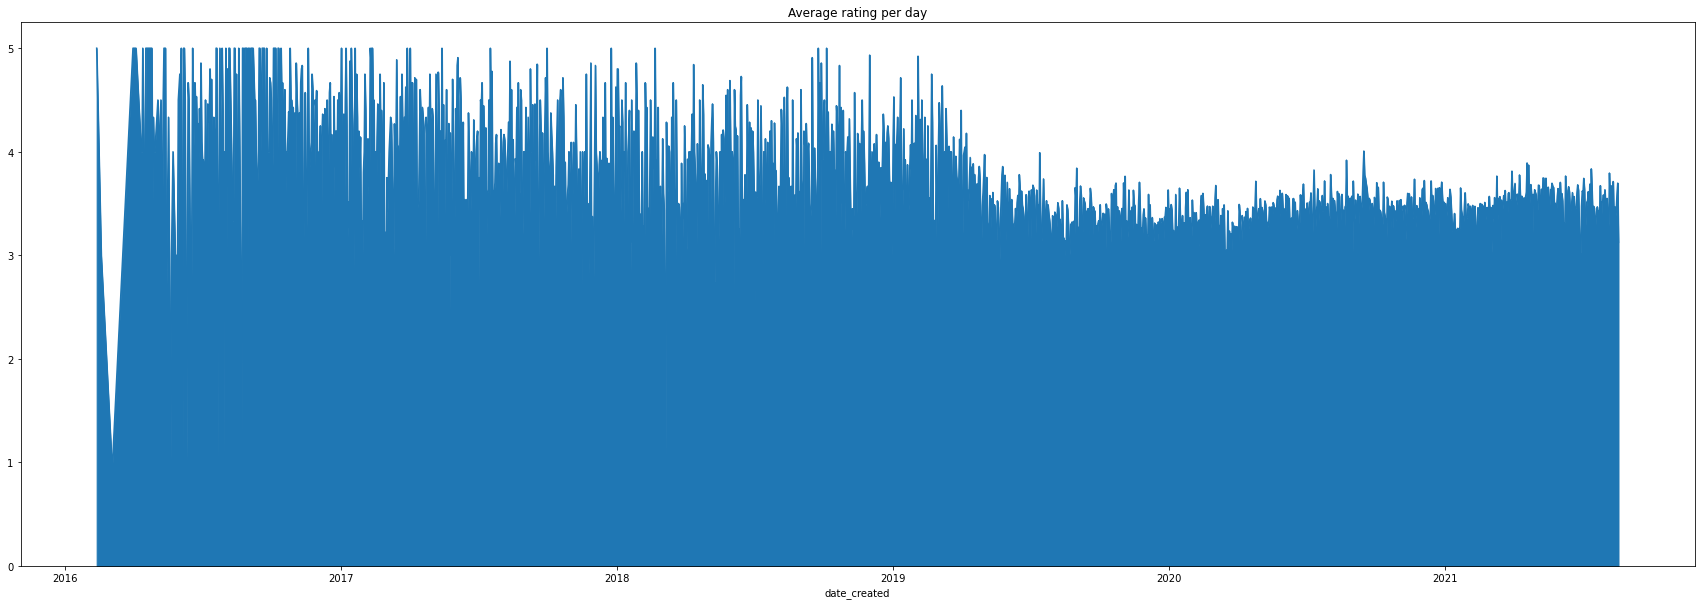

In [14]:
reviewsDf.groupby(reviewsDf['date_created'].dt.date)["rating"].mean().plot(kind='area', figsize=(30, 10), title="Average rating per day")

As this smoothing out matches Ubuntus arrival, it's probably due to there being more ratings per day. So I don't think this shows anything interesting.

# Feedback

If you found a problem with this or have some other ideas, feel free to get in touch or send a pull request!

Thanks for reading.